In [3]:
import ffxiv_stats as ffs

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import json

## Using the `Rotation` class

Using a simple Crit build of SCH from 6.0, accounting for critical hit rate buff from Chain Stratagem.

In [4]:

# Fight duration is 6:35
t = 6 * 60 + 35

# Get rates from Rate class
crit_p = ffs.Rate(2241, 652)
# Account crit rate bonus from chain stratagem with `ch_mod`
crit_p_cs = crit_p.get_p(ch_mod=0.1)

# Create rotation df
ch_rotation_df = pd.DataFrame({
    'd2': [8750, 8750, 3000, 3000, 2075, 2075],
    'n': [132, 22, 8, 22, 115, 10],
    'p': [crit_p.p, crit_p_cs, crit_p.p, crit_p_cs, crit_p.p, crit_p_cs],
    'l_c': [crit_p.l_c]*6,
    'buffs': [None]*6,
    'is_dot': [0, 0, 0, 0, 1, 1],
    'action_name': ['Broil', 'Broil-CS', 'ED', 'ED-CS', 'Bio tick', 'Bio tick-CS'],
    'base_action': ['Broil', 'Broil', 'ED', 'ED', 'Bio tick', 'Bio tick']
})

ch_rotation_df

,d2,n,p,l_c,buffs,is_dot,action_name,base_action
0,8750,132,"[0.702496, 0.22550399999999998, 0.054504, 0.01...",1593.0,None,0,Broil,Broil
1,8750,22,"[0.609696, 0.318304, 0.047304, 0.0246959999999...",1593.0,None,0,Broil-CS,Broil
2,3000,8,"[0.702496, 0.22550399999999998, 0.054504, 0.01...",1593.0,None,0,ED,ED
3,3000,22,"[0.609696, 0.318304, 0.047304, 0.0246959999999...",1593.0,None,0,ED-CS,ED
4,2075,115,"[0.702496, 0.22550399999999998, 0.054504, 0.01...",1593.0,None,1,Bio tick,Bio tick
5,2075,10,"[0.609696, 0.318304, 0.047304, 0.0246959999999...",1593.0,None,1,Bio tick-CS,Bio tick


In [5]:
ch_rotation = ffs.Rotation(ch_rotation_df, t)

### Plot some DPS distributions

The method `ch_rotation.plot_unique_action_distribution()` groups by action, showing DPS distributions for each action (ED, Biolysis Ticks, and Broil IV).

The `ch_rotation.plot_rotation_distribution()` method shows the entire DPS distribution.

Note how axis objects can be given as arguments and edited individually to easily customize plots.

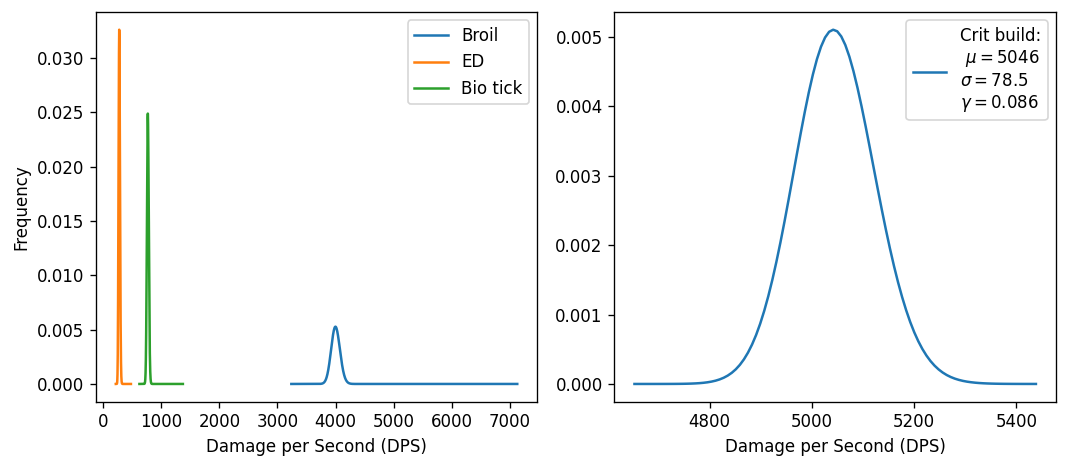

In [7]:
fig, ax = plt.subplots(1,2, figsize=(9,4), dpi=120)

ax[0] = ch_rotation.plot_unique_action_distributions(ax[0])

label_str = f'Crit build:\n $\mu = {ch_rotation.rotation_mean:.0f}$\n$\sigma={ch_rotation.rotation_std:.1f}$\n$\gamma={ch_rotation.rotation_skewness:.3f}$'
ax[1] = ch_rotation.plot_rotation_distribution(ax[1], label=label_str)

ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Damage per Second (DPS)')
ax[1].legend()
plt.tight_layout()
plt.show()

### Compute some percentiles of the DPS distribution.

Suppose you are crit farming and want to if you had a "good" run, i.e., if you sampled the tail of the DPS distribution given your rotation. You can readily see what percentile of the DPS distribution a given run was. Note that small changes between rotations (buff drift, clipping, dropped GCDs, different kill times, etc), will change the underlying rotation DPS distribution you are sampling from. 

These percentiles *are not* related to percentiles from FFLogs in any way, at all.

In [8]:
dx = ch_rotation.rotation_dps_support[1] - ch_rotation.rotation_dps_support[0]
F_c = np.cumsum(ch_rotation.rotation_dps_distribution)*dx


percentile_df = {'percentile': [], 'Crit Build DPS': []}
for p in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]:
    percentile_df['percentile'].append(p*100)
    percentile_df['Crit Build DPS'].append(ch_rotation.rotation_dps_support[np.abs(p - F_c).argmin()])

pd.DataFrame(percentile_df)

,percentile,Crit Build DPS
0,50.0,5044.0
1,60.0,5064.0
2,70.0,5085.5
3,80.0,5111.0
4,90.0,5146.5
5,95.0,5176.5
6,99.0,5233.0


## Using a Role class

Rotation is a SCH opener under raid buffs from a full party. The main difference is there is now a `potency`, `damage-type`, and `main-stat-add` column, which will be used with stats to be converted to a `d2` column and `is-dot` column.

In [9]:
rotation_df = pd.DataFrame({
 "action_name":["Broil IV-Pot",
                "Broil IV-Pot_WM",
                "Broil IV-EM_Mug_Pot_WM",
                "Energy Drain-BH_BL_BV_CS_DIV_EM_Mug_Pot_RF1_WM",
                "Broil IV-BH_BL_BV_CS_DIV_EM_Mug_Pot_RF1_WM",
                "Energy Drain-BH_BL_CS_EM_Mug_Pot_WM",
                "Broil IV-WM",
                "Biolysis Tick-Pot_WM",
                "Biolysis Tick-BH_BL_BV_CS_DIV_EM_Mug_Pot_RF1_WM"
                ],
 "base_action": ["Broil IV",
                 "Broil IV",
                 "Broil IV",
                 "Energy Drain",
                 "Broil IV",
                 "Energy Drain",
                 "Broil IV",
                 "Biolysis Tick",
                 "Biolysis Tick",],
 "potency":[295,295,295,100,295,100,295,70,70],
 "n":[1,2,2,5,5,1,2,7,4],
 "p":[[0.6235649999999999,0.21343499999999999,0.121435,0.041565000000000005],
      [0.606825,0.23017500000000002,0.118175,0.044825000000000004],
      [0.606825,0.23017500000000002,0.118175,0.044825000000000004],
      [0.33442500000000003,0.302575,0.190575,0.172425],
      [0.33442500000000003,0.302575,0.190575,0.172425],
      [0.43942499999999995,0.397575,0.08557500000000001,0.077425],
      [0.606825,0.23017500000000002,0.118175,0.044825000000000004],
      [0.606825,0.23017500000000002,0.118175,0.044825000000000004],
      [0.33442500000000003,0.302575,0.190575,0.172425]],
 "l_c":[1605,1605,1605,1605,1605,1605,1605,1605,1605],
 "buffs":[[],[],[1.05,1.05],[1.05,1.05,1.02,1.05,1.06],[1.05,1.05,1.02,1.05,1.06],[1.05,1.05,1.05],[],[],[1.05,1.05,1.02,1.05,1.06]],
 "damage_type":["direct","direct","direct","direct","direct","direct","direct","magic-dot","magic-dot"],
 "main_stat_add":[223,223,223,223,223,223,0,223,223]
      })

rotation_df

,action_name,base_action,potency,n,p,l_c,buffs,damage_type,main_stat_add
0,Broil IV-Pot,Broil IV,295,1,"[0.6235649999999999, 0.21343499999999999, 0.12...",1605,[],direct,223
1,Broil IV-Pot_WM,Broil IV,295,2,"[0.606825, 0.23017500000000002, 0.118175, 0.04...",1605,[],direct,223
2,Broil IV-EM_Mug_Pot_WM,Broil IV,295,2,"[0.606825, 0.23017500000000002, 0.118175, 0.04...",1605,"[1.05, 1.05]",direct,223
3,Energy Drain-BH_BL_BV_CS_DIV_EM_Mug_Pot_RF1_WM,Energy Drain,100,5,"[0.33442500000000003, 0.302575, 0.190575, 0.17...",1605,"[1.05, 1.05, 1.02, 1.05, 1.06]",direct,223
4,Broil IV-BH_BL_BV_CS_DIV_EM_Mug_Pot_RF1_WM,Broil IV,295,5,"[0.33442500000000003, 0.302575, 0.190575, 0.17...",1605,"[1.05, 1.05, 1.02, 1.05, 1.06]",direct,223
5,Energy Drain-BH_BL_CS_EM_Mug_Pot_WM,Energy Drain,100,1,"[0.43942499999999995, 0.397575, 0.085575000000...",1605,"[1.05, 1.05, 1.05]",direct,223
6,Broil IV-WM,Broil IV,295,2,"[0.606825, 0.23017500000000002, 0.118175, 0.04...",1605,[],direct,0
7,Biolysis Tick-Pot_WM,Biolysis Tick,70,7,"[0.606825, 0.23017500000000002, 0.118175, 0.04...",1605,[],magic-dot,223
8,Biolysis Tick-BH_BL_BV_CS_DIV_EM_Mug_Pot_RF1_WM,Biolysis Tick,70,4,"[0.33442500000000003, 0.302575, 0.190575, 0.17...",1605,"[1.05, 1.05, 1.02, 1.05, 1.06]",magic-dot,223


### Now set up stats and attach a rotation

In [10]:
# Stats from a SCH bis
strength = 350
dex = 392
vit = 2677
intelligence = 410
mind = 2825

crit = 1702
det = 1936
dh = 600

ten = 400

sks = 400
sps = 1035

wd = 123
delay = 3.12

from ffxiv_stats.jobs import Healer

# Main stat, speed stats, and traits are automatically applied with the Healer class
sch = Healer(mind, intelligence, vit, strength, dex, det, sks, sps, ten, crit, dh, wd, delay)
sch.add_job_name('SCH')

# We can see what d2 for a given skill is just by making a Healer object with some stats
print(f'Broil IV d2: {int(sch.direct_d2(295))}')

# Or we can attach our rotation and get a d2 column
sch.attach_rotation(rotation_df, 31) #time = 31s
sch.rotation_df

Broil IV d2: 9387


,action_name,base_action,potency,n,p,l_c,buffs,damage_type,main_stat_add,d2,is_dot
0,Broil IV-Pot,Broil IV,295,1,"[0.6235649999999999, 0.21343499999999999, 0.12...",1605,[],direct,223,10182.0,0
1,Broil IV-Pot_WM,Broil IV,295,2,"[0.606825, 0.23017500000000002, 0.118175, 0.04...",1605,[],direct,223,10182.0,0
2,Broil IV-EM_Mug_Pot_WM,Broil IV,295,2,"[0.606825, 0.23017500000000002, 0.118175, 0.04...",1605,"[1.05, 1.05]",direct,223,10182.0,0
3,Energy Drain-BH_BL_BV_CS_DIV_EM_Mug_Pot_RF1_WM,Energy Drain,100,5,"[0.33442500000000003, 0.302575, 0.190575, 0.17...",1605,"[1.05, 1.05, 1.02, 1.05, 1.06]",direct,223,3451.0,0
4,Broil IV-BH_BL_BV_CS_DIV_EM_Mug_Pot_RF1_WM,Broil IV,295,5,"[0.33442500000000003, 0.302575, 0.190575, 0.17...",1605,"[1.05, 1.05, 1.02, 1.05, 1.06]",direct,223,10182.0,0
5,Energy Drain-BH_BL_CS_EM_Mug_Pot_WM,Energy Drain,100,1,"[0.43942499999999995, 0.397575, 0.085575000000...",1605,"[1.05, 1.05, 1.05]",direct,223,3451.0,0
6,Broil IV-WM,Broil IV,295,2,"[0.606825, 0.23017500000000002, 0.118175, 0.04...",1605,[],direct,0,9387.0,0
7,Biolysis Tick-Pot_WM,Biolysis Tick,70,7,"[0.606825, 0.23017500000000002, 0.118175, 0.04...",1605,[],magic-dot,223,2500.0,1
8,Biolysis Tick-BH_BL_BV_CS_DIV_EM_Mug_Pot_RF1_WM,Biolysis Tick,70,4,"[0.33442500000000003, 0.302575, 0.190575, 0.17...",1605,"[1.05, 1.05, 1.02, 1.05, 1.06]",magic-dot,223,2500.0,1


### Plotting the opener under full raid buffs

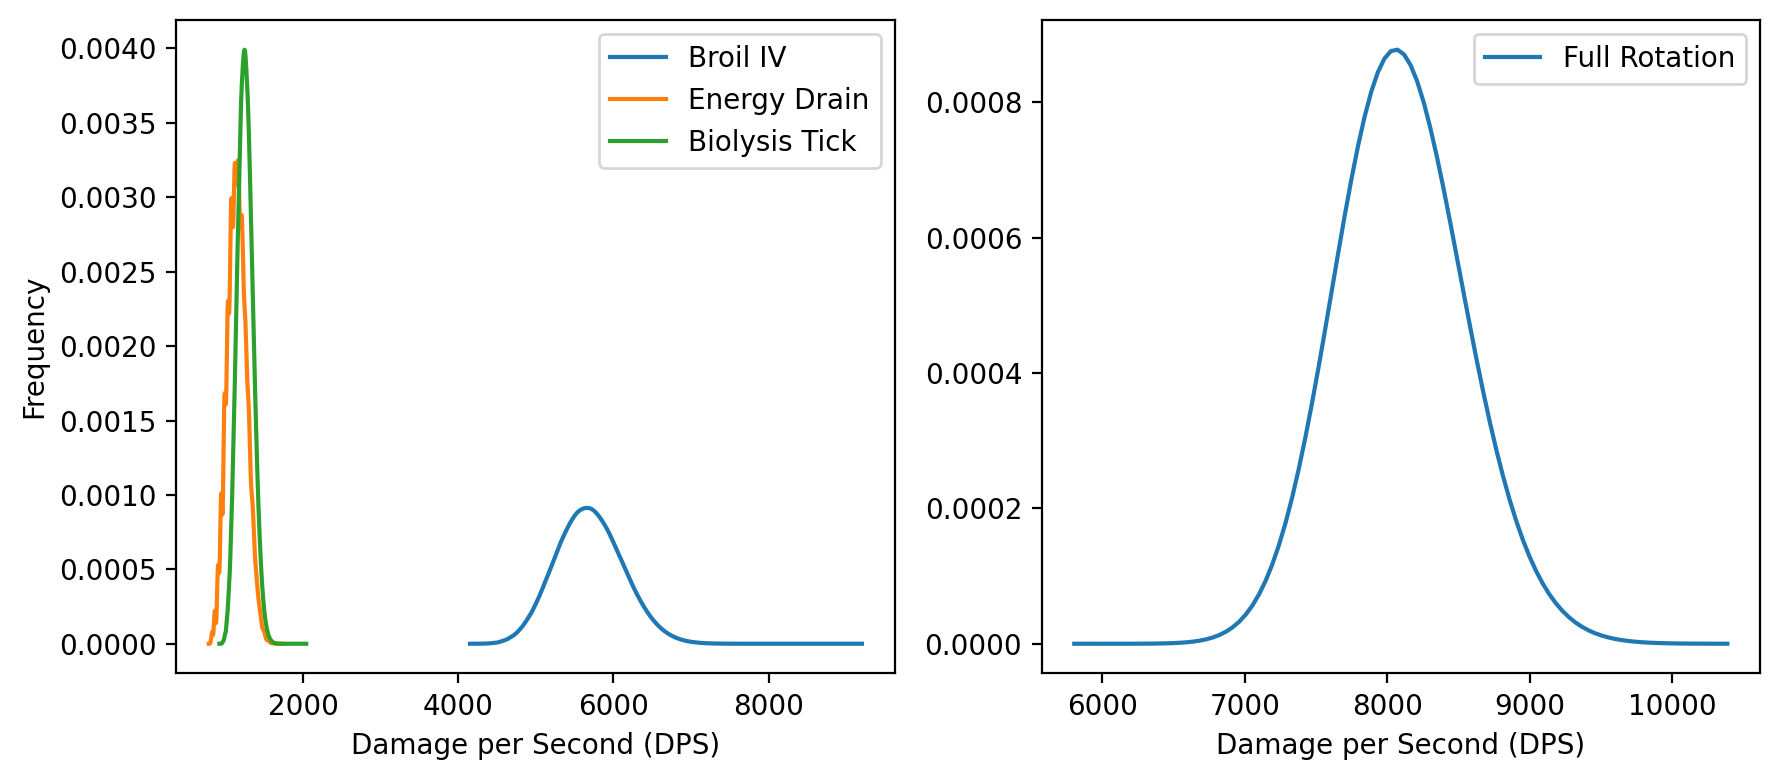

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=200)
ax[0] = sch.plot_unique_action_distributions(ax[0])
ax[1] = sch.plot_rotation_distribution(ax[1], label='Full Rotation')

ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Damage per Second (DPS)')
ax[1].legend()
plt.tight_layout()
plt.show()